# Coupon Collector's Problem - Julia version
*by Roberto Esteban López Díaz*

The problem is as described in many literature and pages such as https://en.wikipedia.org/wiki/Coupon_collector's_problem
This program is writen to do simulation over to test the bounds from the expected value and variance calculated as shown in Mitzenmacher, Upfal's book chapter 2 and 3.

In [162]:
using PyCall
using Random
using Statistics
import PyPlot; const plt = PyPlot

PyPlot

In [150]:
function coupon_collecter(coupons::Int, samples::Int)
    k = 1
    tests = zeros(Int, samples)
    Random.seed!(convert(Int64,time_ns() % 2^32)) ## New seed for the execution
    while k <= samples ### In this while executes all the samples of the experiments. Aka run it k times.
        my_collection = zeros(Int8, coupons)
        my_coupons = 0
        tries = 0
        while my_coupons < coupons ### Completing one run in this while. To collect all the coupons
            new_coupon = rand(1:coupons)
            if my_collection[new_coupon] == 0 ## This is a new coupon to the collection
                my_collection[new_coupon] = 1 
                my_coupons += 1
            end
            tries += 1
        end
        tests[k] = tries
        k += 1
    end
    return tests
end

function get_collection(coupons_range, samples::Int)
    println("Doing ",length(coupons_range), " different collections with ",samples," samples.")
    tests = zeros(Int, length(coupons_range), samples)
    start = 0
    j = 1
    for coupons in coupons_range
        if coupons % 10 == 1 
            start = time_ns()
        end
        results = coupon_collecter(coupons, samples)
        for i in range(1, stop=samples)
            tests[j, i] = results[i]
        end
        j += 1
        if coupons % 10 == 0
            println("Going in ",coupons," coupons in ",(time_ns()-start)/10^6, "ms")
        end
    end
    return tests
end

For this experiment there are two paramerts, the maximum number of coupons for a collection to have and the number of samples per coupon collection to execute. The total of each experiment will be store in a list, this to calculate its mean and variance later(there could be better optimization in space, but for now is omited for little numbers).

In [203]:
coupons_range = range(1, stop=200)
coupons_range_log = [1 10 10^2 10^3 10^4 10^5 10^6]'
samples = 500
tests = get_collection(coupons_range, samples)
tests_log = get_collection(coupons_range_log, samples) 

Doing 200 different collections with 500 samples.
Going in 10 coupons in 2.411001ms
Going in 20 coupons in 8.478399ms
Going in 30 coupons in 13.2127ms
Going in 40 coupons in 19.616901ms
Going in 50 coupons in 33.555301ms
Going in 60 coupons in 26.1252ms
Going in 70 coupons in 37.5935ms
Going in 80 coupons in 49.589301ms
Going in 90 coupons in 51.759001ms
Going in 100 coupons in 62.223ms
Going in 110 coupons in 48.0077ms
Going in 120 coupons in 57.508199ms
Going in 130 coupons in 67.3129ms
Going in 140 coupons in 109.2405ms
Going in 150 coupons in 120.757299ms
Going in 160 coupons in 111.525999ms
Going in 170 coupons in 120.0441ms
Going in 180 coupons in 137.587901ms
Going in 190 coupons in 134.1603ms
Going in 200 coupons in 135.661099ms
Doing 7 different collections with 500 samples.
Going in 10 coupons in 0.649999ms
Going in 100 coupons in 7.449399ms
Going in 1000 coupons in 88.682299ms
Going in 10000 coupons in 1314.5018ms
Going in 100000 coupons in 12903.0712ms
Going in 1000000 coup

7×500 Array{Int64,2}:
        1         1         1         1  …         1         1         1
       21        26        42        17           31        41        51
      458       312       483       359          752       716       553
     7228      8703      6579      6276         6488      5423      5288
    89629    106593     95507     90277       124665     79929     86424
  1104447   1253076   1303648   1448414  …   1172725   1062351   1099220
 13383705  14624395  13474839  13888866     14287955  14698859  13703359

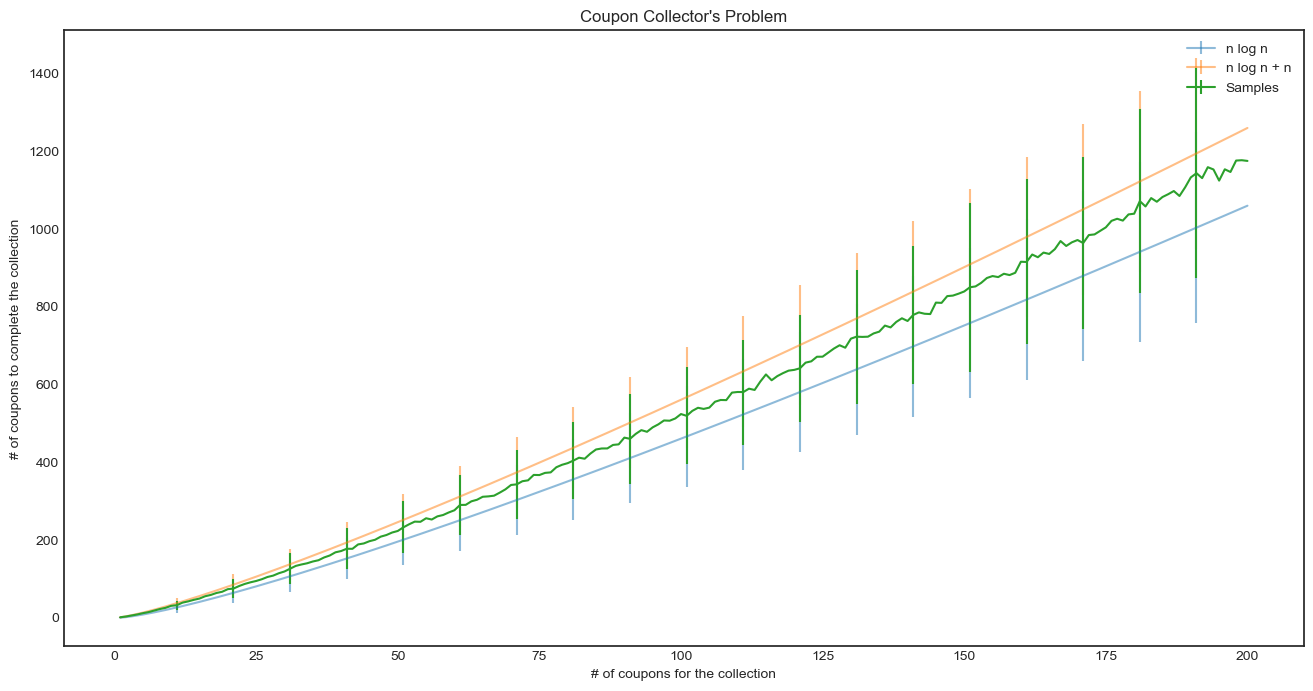

PyObject <matplotlib.legend.Legend object at 0x0000000033951E48>

In [206]:
error_each = 10 ## in how many steps an erros bar is showed
fig, axs = plt.subplots(figsize=(16,8))
scale = coupons_range
axs.errorbar(scale, [(j*log(j)) for j in coupons_range], [(n*pi) / sqrt(6) for n in coupons_range],
             label="n log n", alpha = 0.5, errorevery=error_each)
axs.errorbar(scale, [j*log(j) + j for j in coupons_range], [(n*pi) / sqrt(6) for n in coupons_range],
             label="n log n + n", alpha = 0.5, errorevery=error_each)
axs.errorbar(scale, mean(tests, dims=2), [sqrt(x) for x in var(tests, dims=2)], 
            label="Samples", errorevery=error_each)
#axs.locator_params(nbins=20)
axs.set_xlabel("# of coupons for the collection")
axs.set_ylabel("# of coupons to complete the collection")
plt.title("Coupon Collector\'s Problem")
plt.legend()

Now to analyze further the behavior of the problem, we will make more experiments with more samples to compare the probability of $P(X \leq n \ln n + cn)$. This time just for a previous ticket collection sampled.

In [217]:
cs = range(-5, step=0.25, length=40)
P_x = zeros(Float64, length(coupons_range_log), length(cs))
i = 1
for coupons in coupons_range_log ## Loop to evaluate the probability of an event to happend be bound by the 
    actual_collection = tests_log[i,:]
    probs = zeros(Float64, length(cs))
    j = 1
    for ci in cs ### loop for the values of c
        P = coupons*log(coupons) + ci*coupons
        P_for_ci = 0
        for result in actual_collection ### Iterating the results for a given collection
            if result <= P
                P_for_ci += 1
            end
        end
        probs[j] = (P_for_ci / samples)
        j += 1
    end
    for l in range(1, stop=length(probs))
        P_x[i,l] = probs[l]
    end
    i += 1
end

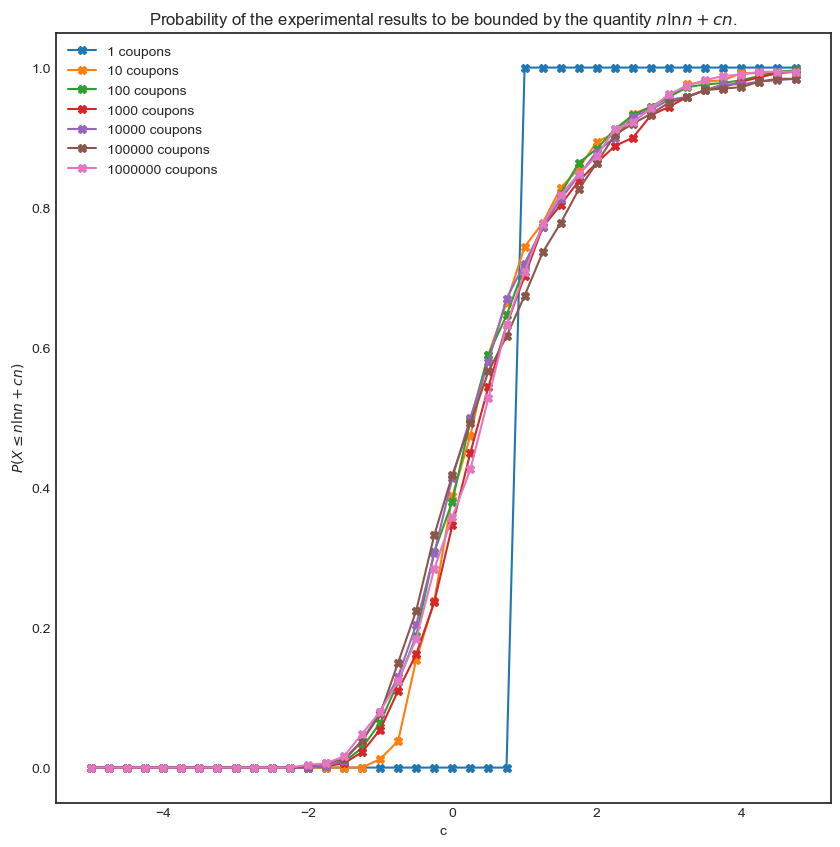

PyObject <matplotlib.legend.Legend object at 0x000000005BFE22B0>

In [238]:
fig, axs = plt.subplots(figsize=(10,10))
plt.title("Probability of the experimental results to be bounded by the quantity \$n \\ln n + cn\$.")
i = 1
for coupons in coupons_range_log
    label = string(coupons, " coupons")
    plt.plot(convert(Array, cs), P_x[i,:], marker="X", label=label)
    i += 1
end
axs.set_xlabel("c")
axs.set_ylabel("\$P(X \\leq n \\ln n + cn)\$")
plt.legend()

Now is time to compare the evaluation of the perfomance between python and julia executing the most analogous code to sample the expriments for the same imputs. The graphing perfomance will be not evaluated as both are using PyPlot from python.

In [247]:
### Python world of functions
py"""
import numpy as np
import numpy.random as rdm
import time
import math

class coupon_collect: # A more versatile form to call the simulation and run it as many times as required.
    def __init__(self, unique_items):
        self.unique_items = unique_items ## Saves the total different coupons the problem have.
        rdm.seed(int(time.time())) ###New seed each execution from the clock of the machine.
        self.tests = []
        
    def sample(self, samples): ## Call it to execute a number of samples, it returns a list with the result from each run.
        k = 0
        tests = []
        while k < samples: ### In this while executes all the samples of the experiments. Aka run it k times.
            my_collection = np.zeros(self.unique_items, dtype=np.uint8)
            my_coupons = 0
            tries = 0
            while my_coupons < self.unique_items:### Completing one run in this while. To collect all the coupons
                new_coupon = rdm.randint(0, high=self.unique_items)
                if my_collection[new_coupon] == 0: ## This is a new coupon to the collection
                    my_collection[new_coupon] = 1 
                    my_coupons += 1
                tries += 1
            self.tests.append(tries)
            k += 1
    
    def tests(self):
        return self.tests
"""

In [255]:
reps = 10
test_coupons = [10, 10^2, 10^3, 10^4]'
times_jl = Array{Float64}(undef, length(test_coupons),reps)
times_py = Array{Float64}(undef, length(test_coupons),reps)
i = 1
for coupon in test_coupons
    j = 1
    while j <= reps
        t = time_ns()
        collector_py = py"coupon_collect"(coupon)
        collector_py.sample(100)
        times_py[i,j] = (time_ns() - t) / 10^6
        t = time_ns()
        get_collection(coupon, 100)
        times_jl[i,j] = (time_ns() - t) / 10^6
        j += 1
    end
    i += 1
end

Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.54356846249999e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.54356884013299e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.54356938458399e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.54356978477999e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.54357015666399e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.543570503598e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.543570886422e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.543571245304e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.543571586221e8ms
Doing 1 different collections with 100 samples.
Going in 10 coupons in 5.543571944885e8ms
Doing 1 different collections with 100 samples.
Going in 100 coupons in 5.543577363513e8ms

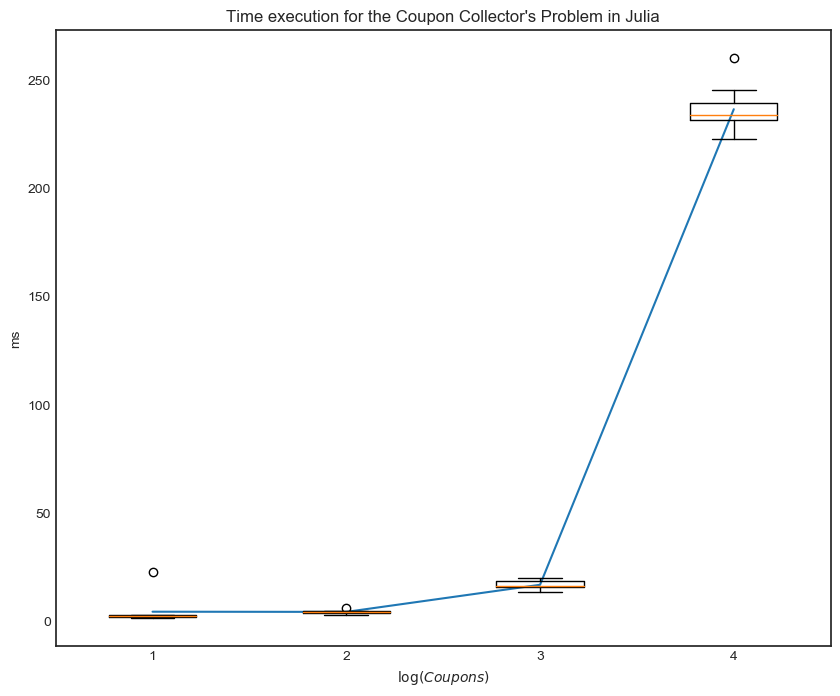

PyObject Text(0.5, 1, "Time execution for the Coupon Collector's Problem in Julia")

In [271]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot([log(10,x) for x in test_coupons]', mean(times_jl, dims=2))
plt.boxplot(times_jl')
ax.set_xlabel("\$ \\log(Coupons)\$")
ax.set_ylabel("ms")
plt.title("Time execution for the Coupon Collector's Problem in Julia")

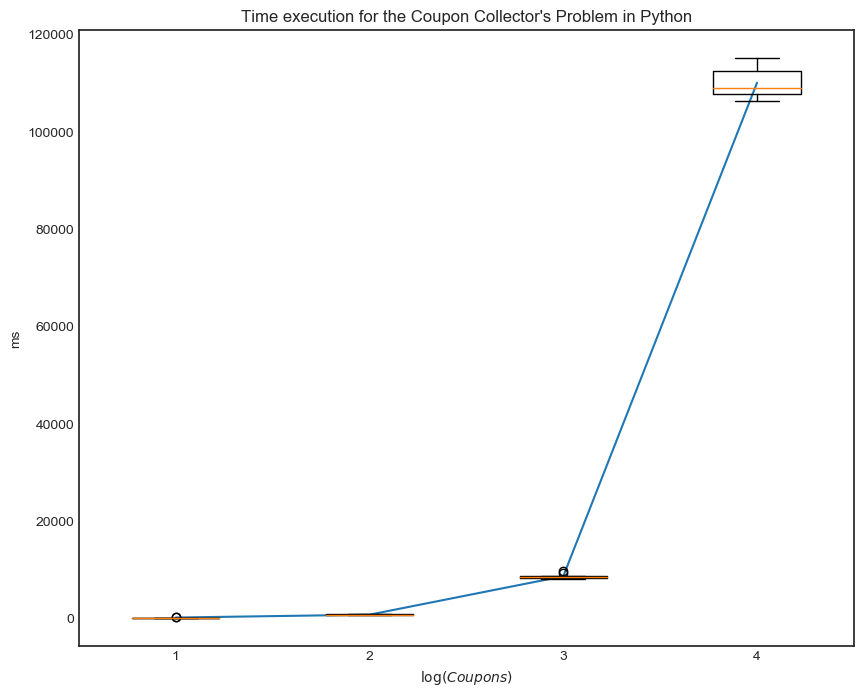

PyObject Text(0.5, 1, "Time execution for the Coupon Collector's Problem in Python")

In [272]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot([log(10,x) for x in test_coupons]', mean(times_py, dims=2))
plt.boxplot(times_py')
ax.set_xlabel("\$ \\log(Coupons)\$")
ax.set_ylabel("ms")
plt.title("Time execution for the Coupon Collector's Problem in Python")

Comparing the graphs, the behave very alike as one can expect as they are coded alike with the same complexity, but the difference in the constant of the implementation is greatly between Julia and Python, which again Julia is at least 100 times faster.